<a href="https://colab.research.google.com/github/tsmanral/Author-Prediction-Using-Deep-Learning-Models/blob/master/Model_for_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D
from keras.layers import Flatten, GlobalAveragePooling1D
from keras.layers import Embedding, TimeDistributed
import keras.utils
from keras.callbacks import ModelCheckpoint  


Using TensorFlow backend.


In [0]:
## extra imports to set GPU options
import tensorflow as tf
from keras import backend as k
###################################
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.9
 
# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))
###################################

In [0]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))


TensorFlow Version: 1.6.0
Default GPU Device: /device:GPU:0


In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data_clean')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
file_list = drive.ListFile(
    {'q': "'1W_ncgu50M_LR65A4jVvCuFklmosjIfpz' in parents"}).GetList()

data = []
for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)
  with open(fname, 'r', encoding = "ISO-8859-1") as file:
    data.append([f['title'].split('-')[0], file.read()])

title: Humphrey Ward - 14.txt, id: 1KQ8TIQFtWWWJhsp6QIpn5RGhYO7NQ3wk
downloading to /content/data_clean/Humphrey Ward - 14.txt
title: Humphrey Ward - 16.txt, id: 1Xx6zE79WHWVFowU477l1YPGYMnEd4uCn
downloading to /content/data_clean/Humphrey Ward - 16.txt
title: Humphrey Ward - 19.txt, id: 1T9QE_hSZUx17oa7QGekYM23SIgLSfsE4
downloading to /content/data_clean/Humphrey Ward - 19.txt
title: Humphrey Ward - 17.txt, id: 1xx-umzzZFNncv9X8OWWj4auY60ShAE-8
downloading to /content/data_clean/Humphrey Ward - 17.txt
title: Humphrey Ward - 15.txt, id: 1CsLYGbi6pirecPBPNwli90Sb-XSM8q33
downloading to /content/data_clean/Humphrey Ward - 15.txt
title: Humphrey Ward - 18.txt, id: 1EULi5tNbF07SbrhycdDj_u58MVe8te2N
downloading to /content/data_clean/Humphrey Ward - 18.txt
title: Humphrey Ward - 13.txt, id: 15za4_hyAnLyw9xALmmp3R54m-ZfGtnjv
downloading to /content/data_clean/Humphrey Ward - 13.txt
title: Humphrey Ward - 9.txt, id: 1ZwNeiFvLOHUXsAJHUvC2PIJupsxT89Ne
downloading to /content/data_clean/Humphrey

title: Henry Rider Haggard - 2.txt, id: 182DLelFZVUwgVCXgMYqyljcdeVekKLyg
downloading to /content/data_clean/Henry Rider Haggard - 2.txt
title: Henry Rider Haggard - 4.txt, id: 1RW0VikO9suP-fdX6U9WlmPnC47Pw_gTV
downloading to /content/data_clean/Henry Rider Haggard - 4.txt
title: Gilbert Parker - 14.txt, id: 1PtwJLsc_phb72-juruLNQWBWJgzbY2gk
downloading to /content/data_clean/Gilbert Parker - 14.txt
title: Henry Rider Haggard - 6.txt, id: 103UEqkdS8kQsRH9WWQqY2I3jM0pwHRj1
downloading to /content/data_clean/Henry Rider Haggard - 6.txt
title: Henry Rider Haggard - 1.txt, id: 1kxRrRkIluKMT-OZLdo6vqoWiUcGX23qN
downloading to /content/data_clean/Henry Rider Haggard - 1.txt
title: Gilbert Parker - 16.txt, id: 17na4xSvHKXD5OmCeJYiHVyf3YWnONGNs
downloading to /content/data_clean/Gilbert Parker - 16.txt
title: Henry Rider Haggard - 3.txt, id: 10P8MfJtE9KcHf9DwutglKBuSFVbi3GTx
downloading to /content/data_clean/Henry Rider Haggard - 3.txt
title: Gilbert Parker - 15.txt, id: 1RsBp3uXa_WruUJeYPAP0

title: George Gissing - 2.txt, id: 1TgeehcW7iqntOfbRLH8iy1I15XBVdaxj
downloading to /content/data_clean/George Gissing - 2.txt
title: George Gissing - 1.txt, id: 1KDkLX5NHiTSltmuM62AjHLvysn9YIOsr
downloading to /content/data_clean/George Gissing - 1.txt
title: Arthur Conan Doyle - 16.txt, id: 1x7aFEQd4B22hXRhgcXtFqpFynrELXh_1
downloading to /content/data_clean/Arthur Conan Doyle - 16.txt
title: Arthur Conan Doyle - 11.txt, id: 1r5sFr40dIr6fRkcxLSKnGFGAAAA6S5pT
downloading to /content/data_clean/Arthur Conan Doyle - 11.txt
title: Arthur Conan Doyle - 14.txt, id: 1Il1phCs0DRuvcGPWCeTBZxBhyrzuNvJd
downloading to /content/data_clean/Arthur Conan Doyle - 14.txt
title: Arthur Conan Doyle - 17.txt, id: 1WO8c4eGI0PrkbgPKuycecVefuVn8PRfK
downloading to /content/data_clean/Arthur Conan Doyle - 17.txt
title: Arthur Conan Doyle - 13.txt, id: 1FePgEn_ZEgdeqWtdJyI5PNR8RXAlSCas
downloading to /content/data_clean/Arthur Conan Doyle - 13.txt
title: Arthur Conan Doyle - 12.txt, id: 1BU0YcOr-_2EbjkxSrPuw

In [0]:
X = []
for _,c in data:
    X.append(c.lower())
    
Y = []
for i,_ in data:
    Y.append(i.lower())

X1 = []
Y_data1 = []

for text in X:
  c = text.strip().split()
  X1.append(c)

print(len(X))
X_data1 = []
count = 0
for i in X1:
  m=0
  n=1000
  times = len(i)//1000
  for j in range(times):
    X_data1.append(i[m:n])
    m = m + 1000
    n = n + 1000
    Y_data1.append(Y[count]) 
  X_data1.append(i[m:len(i)+1])
  Y_data1.append(Y[count])
  count = count + 1 



98


In [0]:
temp_list = []
for i in range(len(X_data1)):
  temp_list.append([X_data1[i], Y_data1[i]])
print(len(temp_list))
print(temp_list[0][1])

import random

random.shuffle(temp_list)
print(len(temp_list))
print(temp_list[0][1])

X_data = []
Y_data = []
for i in range(len(temp_list)):
  X_data.append(temp_list[i][0])
  Y_data.append(temp_list[i][1])
print(len(X_data), len(Y_data))
print(X_data[0], Y_data[0])

10078
humphrey ward 
10078
henry rider haggard 
10078 10078
['fire', 'be', 'fierce', 'enough', 'but', 'i', 'said', 'nothing', 'and', 'though', 'my', 'hand', 'trembled', 'i', 'once', 'more', 'grasped', 'the', 'daggers', 'hilt', 'and', 'wild', 'with', 'fear', 'at', 'my', 'own', 'weakness', 'set', 'myself', 'to', 'find', 'a', 'means', 'to', 'slay', 'her', 'while', 'yet', 'my', 'sense', 'remained', 'come', 'hither', 'harmachis', 'she', 'went', 'on', 'in', 'her', 'softest', 'voice', 'come', 'sit', 'by', 'me', 'and', 'we', 'will', 'talk', 'together', 'for', 'i', 'have', 'much', 'to', 'tell', 'thee', 'and', 'she', 'made', 'place', 'for', 'me', 'at', 'her', 'side', 'upon', 'the', 'silken', 'seat', 'and', 'i', 'thinking', 'that', 'i', 'might', 'so', 'more', 'swiftly', 'strike', 'rose', 'and', 'seated', 'myself', 'some', 'little', 'way', 'from', 'her', 'on', 'the', 'couch', 'while', 'flinging', 'back', 'her', 'head', 'she', 'gazed', 'on', 'me', 'with', 'her', 'slumbrous', 'eyes', 'now', 'was', '

In [0]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Converting Output values to One Hot Vector
print("Converting to One hot vector(training set)...")
Y_data = np.array(Y_data)

label_encoder = LabelEncoder()
train_integer_encoded = label_encoder.fit_transform(Y_data)
print(train_integer_encoded)


Converting to One hot vector(training set)...
[3 3 0 ... 4 4 3]


In [0]:
train_onehot_encoded = keras.utils.to_categorical(train_integer_encoded)
print(train_onehot_encoded[2841,:])

[0. 0. 0. 1. 0.]


In [0]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(X_data)
vocab_size = len(t.word_index) + 1
print(vocab_size)

128625


In [0]:
# integer encode the documents
encoded_docs = t.texts_to_sequences(X_data)
print(encoded_docs[0])

[331, 25, 1020, 213, 21, 6, 31, 141, 2, 128, 28, 116, 1853, 6, 140, 63, 2938, 1, 12106, 4317, 2, 572, 17, 334, 20, 28, 105, 1506, 271, 258, 4, 227, 5, 479, 4, 2527, 12, 162, 119, 28, 395, 675, 74, 2017, 2518, 15, 131, 27, 7, 12, 10485, 158, 74, 596, 36, 29, 2, 45, 52, 240, 282, 18, 6, 26, 106, 4, 148, 356, 2, 15, 96, 195, 18, 29, 20, 12, 219, 54, 1, 9195, 882, 2, 6, 534, 10, 6, 111, 37, 63, 1392, 1383, 275, 2, 918, 258, 67, 68, 115, 32, 12, 27, 1, 2685, 162, 9091, 100, 12, 151, 15, 1234, 27, 29, 17, 12, 30573, 86, 56, 9, 28, 1189, 18, 12, 1100, 2, 772, 39, 1577, 2, 17, 5, 1828, 880, 140, 94, 6, 792, 28, 116, 4, 10819, 1, 57481, 21, 63, 581, 81, 118, 15, 443, 28, 738, 17, 12, 105, 2, 1112, 285, 49, 147, 22556, 269, 37, 3739, 2518, 15, 31, 712, 1090, 1631, 1090, 196, 6, 2061, 50, 3643, 269, 27, 1, 6131, 2, 363, 356, 15, 154, 120, 858, 28, 116, 32, 30, 1, 544, 16, 1477, 1, 1191, 52, 633, 518, 139, 122, 1518, 269, 5819, 17, 451, 1774, 88, 833, 24, 1, 178, 323, 10, 9667, 32, 803, 8994, 634,

In [0]:
# pad documents to a max length of 10000 words
max_length =1000
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

[[  331    25  1020 ...    41  2527     5]
 [ 4233   221     1 ...    13    58   625]
 [  199    42    18 ...    58     1  7653]
 ...
 [    5  1792   238 ...    12    69     1]
 [  555  1011 37439 ...  2147    31     4]
 [  762   278     5 ...    87    10   299]]


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data_clean')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
file_list = drive.ListFile(
    {'q': "'1ogZLyJ5GTI8a0o8HPac8zTtm96SzCv-k' in parents"}).GetList()
print(file_list[0]['title'], file_list[0]['id'] )
fname = os.path.join(local_download_path, file_list[0]['title'])
f_ = drive.CreateFile({'id': file_list[0]['id']})
f_.GetContentFile(fname)


# load the whole embedding into memory
embeddings_index = dict()
f = open(fname)
for line in f:
	values = line.split()
	word = values[0]
	coefs = asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

glove.6B.100d.txt 17BmrNJa4oJDNg3KZ6u2Ww0ETQYklOJJ7
Loaded 400000 word vectors.


In [0]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 100))
for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

(128625, 100)


In [0]:
print(padded_docs.shape)
doc_train = np.array(padded_docs[0:8000,:])
print(doc_train.shape)
doc_test = np.array(padded_docs[8000:,:])
print(doc_test.shape)

onehot_train = np.array(train_onehot_encoded[0:8000,:])
print(onehot_train.shape)
onehot_test = np.array(train_onehot_encoded[8000:,:])
print(onehot_test.shape)

(10078, 1000)
(8000, 1000)
(2078, 1000)
(8000, 5)
(2078, 5)


In [0]:
# define model
model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=1000, trainable=False)
model.add(e)
#model.add(Conv1D(32, 3, border_mode='valid'))
#model.add(Conv1D(64, 3, border_mode='valid'))
model.add(LSTM(512, activation='tanh', return_sequences=False))

#model.add(GlobalAveragePooling1D())

#model.add(Dropout(0.3))
#model.add(Flatten())
#model.add(Dense(5000, activation='relu'))
#model.add(Dropout(0.1))


#model.add(Dense(1000, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dropout(0.6))

model.add(Dense(500, activation='relu', kernel_initializer='glorot_uniform'))
model.add(Dropout(0.6))




model.add(Dense(5, activation='softmax'))
#model.add(TimeDistributed(Dense(100, activation='softmax')))

In [0]:
# compile the model
num_of_epochs = 100
batchsize = 256
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [0]:
# summarize the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         12862500  
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               1255424   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               256500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2505      
Total params: 14,376,929
Trainable params: 1,514,429
Non-trainable params: 12,862,500
________________________________________________________

In [0]:
checkpointer = ModelCheckpoint(filepath='/content/weights.best.RNN.hdf5', 
                               verbose=1, save_best_only=True)

In [0]:
# fit the model
history = model.fit(doc_train, onehot_train, epochs=num_of_epochs, verbose=1, batch_size=batchsize, callbacks=[checkpointer], validation_split=0.2)

Train on 6400 samples, validate on 1600 samples
Epoch 1/100
6400/6400 [==============================] - 81s 13ms/step - loss: 1.6107 - categorical_accuracy: 0.2619 - val_loss: 1.5567 - val_categorical_accuracy: 0.2781

Epoch 00001: val_loss improved from inf to 1.55667, saving model to /content/weights.best.RNN.hdf5
Epoch 2/100
6400/6400 [==============================] - 79s 12ms/step - loss: 1.5711 - categorical_accuracy: 0.2827 - val_loss: 1.5506 - val_categorical_accuracy: 0.3063

Epoch 00002: val_loss improved from 1.55667 to 1.55060, saving model to /content/weights.best.RNN.hdf5
Epoch 3/100
6400/6400 [==============================] - 79s 12ms/step - loss: 1.5548 - categorical_accuracy: 0.3067 - val_loss: 1.5141 - val_categorical_accuracy: 0.3450

Epoch 00003: val_loss improved from 1.55060 to 1.51406, saving model to /content/weights.best.RNN.hdf5
Epoch 4/100
6400/6400 [==============================] - 79s 12ms/step - loss: 1.5778 - categorical_accuracy: 0.3219 - val_loss: 1.

6400/6400 [==============================] - 79s 12ms/step - loss: 1.5246 - categorical_accuracy: 0.3489 - val_loss: 1.5127 - val_categorical_accuracy: 0.3444

Epoch 00006: val_loss did not improve
Epoch 7/100
6400/6400 [==============================] - 79s 12ms/step - loss: 1.5237 - categorical_accuracy: 0.3605 - val_loss: 2.3576 - val_categorical_accuracy: 0.2412

Epoch 00007: val_loss did not improve
Epoch 8/100
6400/6400 [==============================] - 79s 12ms/step - loss: 1.5364 - categorical_accuracy: 0.3408 - val_loss: 1.4844 - val_categorical_accuracy: 0.3625

Epoch 00008: val_loss improved from 1.49439 to 1.48438, saving model to /content/weights.best.RNN.hdf5
Epoch 9/100
6400/6400 [==============================] - 79s 12ms/step - loss: 1.6230 - categorical_accuracy: 0.3716 - val_loss: 1.5710 - val_categorical_accuracy: 0.2681

Epoch 00009: val_loss did not improve
Epoch 10/100
6400/6400 [==============================] - 79s 12ms/step - loss: 1.4519 - categorical_accura

6400/6400 [==============================] - 79s 12ms/step - loss: 1.4808 - categorical_accuracy: 0.3894 - val_loss: 1.4656 - val_categorical_accuracy: 0.3831

Epoch 00011: val_loss did not improve
Epoch 12/100
6400/6400 [==============================] - 79s 12ms/step - loss: 1.4143 - categorical_accuracy: 0.4106 - val_loss: 1.2882 - val_categorical_accuracy: 0.4725

Epoch 00012: val_loss improved from 1.36243 to 1.28824, saving model to /content/weights.best.RNN.hdf5
Epoch 13/100
6400/6400 [==============================] - 79s 12ms/step - loss: 1.3824 - categorical_accuracy: 0.4417 - val_loss: 1.5058 - val_categorical_accuracy: 0.3937

Epoch 00013: val_loss did not improve
Epoch 14/100
6400/6400 [==============================] - 79s 12ms/step - loss: 1.3961 - categorical_accuracy: 0.4169 - val_loss: 1.3512 - val_categorical_accuracy: 0.4206

Epoch 00014: val_loss did not improve
Epoch 15/100
6400/6400 [==============================] - 79s 12ms/step - loss: 1.3038 - categorical_acc

6400/6400 [==============================] - 79s 12ms/step - loss: 1.3057 - categorical_accuracy: 0.4683 - val_loss: 1.6227 - val_categorical_accuracy: 0.2769

Epoch 00016: val_loss did not improve
Epoch 17/100
6400/6400 [==============================] - 79s 12ms/step - loss: 1.3285 - categorical_accuracy: 0.4656 - val_loss: 1.1935 - val_categorical_accuracy: 0.5088

Epoch 00017: val_loss improved from 1.23214 to 1.19349, saving model to /content/weights.best.RNN.hdf5
Epoch 18/100
6400/6400 [==============================] - 79s 12ms/step - loss: 1.2217 - categorical_accuracy: 0.5144 - val_loss: 1.3165 - val_categorical_accuracy: 0.4562

Epoch 00018: val_loss did not improve
Epoch 19/100
6400/6400 [==============================] - 80s 12ms/step - loss: 1.2354 - categorical_accuracy: 0.5027 - val_loss: 1.1474 - val_categorical_accuracy: 0.5444

Epoch 00019: val_loss improved from 1.19349 to 1.14736, saving model to /content/weights.best.RNN.hdf5
Epoch 20/100
6400/6400 [===============

6400/6400 [==============================] - 80s 12ms/step - loss: 1.2055 - categorical_accuracy: 0.5206 - val_loss: 1.1341 - val_categorical_accuracy: 0.5606

Epoch 00021: val_loss did not improve
Epoch 22/100
6400/6400 [==============================] - 80s 12ms/step - loss: 1.1528 - categorical_accuracy: 0.5377 - val_loss: 1.0461 - val_categorical_accuracy: 0.5794

Epoch 00022: val_loss improved from 1.12064 to 1.04614, saving model to /content/weights.best.RNN.hdf5
Epoch 23/100
6400/6400 [==============================] - 80s 12ms/step - loss: 1.1580 - categorical_accuracy: 0.5398 - val_loss: 1.4126 - val_categorical_accuracy: 0.3987

Epoch 00023: val_loss did not improve
Epoch 24/100
6400/6400 [==============================] - 80s 12ms/step - loss: 1.1164 - categorical_accuracy: 0.5628 - val_loss: 1.3462 - val_categorical_accuracy: 0.4988

Epoch 00024: val_loss did not improve
Epoch 25/100
6400/6400 [==============================] - 80s 12ms/step - loss: 1.1400 - categorical_acc

6400/6400 [==============================] - 80s 12ms/step - loss: 1.0777 - categorical_accuracy: 0.5862 - val_loss: 1.0609 - val_categorical_accuracy: 0.6031

Epoch 00026: val_loss did not improve
Epoch 27/100
6400/6400 [==============================] - 80s 12ms/step - loss: 0.9977 - categorical_accuracy: 0.6339 - val_loss: 1.7648 - val_categorical_accuracy: 0.3556

Epoch 00027: val_loss did not improve
Epoch 28/100
6400/6400 [==============================] - 80s 12ms/step - loss: 1.0186 - categorical_accuracy: 0.6091 - val_loss: 0.9470 - val_categorical_accuracy: 0.6281

Epoch 00028: val_loss improved from 1.04614 to 0.94703, saving model to /content/weights.best.RNN.hdf5
Epoch 29/100
6400/6400 [==============================] - 80s 12ms/step - loss: 0.9565 - categorical_accuracy: 0.6364 - val_loss: 1.0648 - val_categorical_accuracy: 0.6088

Epoch 00029: val_loss did not improve
Epoch 30/100
6400/6400 [==============================] - 79s 12ms/step - loss: 0.9449 - categorical_acc

6400/6400 [==============================] - 79s 12ms/step - loss: 0.8809 - categorical_accuracy: 0.6758 - val_loss: 0.8642 - val_categorical_accuracy: 0.6869

Epoch 00031: val_loss did not improve
Epoch 32/100
6400/6400 [==============================] - 79s 12ms/step - loss: 0.9029 - categorical_accuracy: 0.6675 - val_loss: 0.7767 - val_categorical_accuracy: 0.7306

Epoch 00032: val_loss improved from 0.86317 to 0.77667, saving model to /content/weights.best.RNN.hdf5
Epoch 33/100
6400/6400 [==============================] - 80s 12ms/step - loss: 0.8328 - categorical_accuracy: 0.7077 - val_loss: 0.8425 - val_categorical_accuracy: 0.7094

Epoch 00033: val_loss did not improve
Epoch 34/100
6400/6400 [==============================] - 80s 12ms/step - loss: 0.8255 - categorical_accuracy: 0.6955 - val_loss: 0.7903 - val_categorical_accuracy: 0.7381

Epoch 00034: val_loss did not improve
Epoch 35/100
6400/6400 [==============================] - 80s 12ms/step - loss: 0.8438 - categorical_acc

6400/6400 [==============================] - 80s 12ms/step - loss: 0.7948 - categorical_accuracy: 0.6948 - val_loss: 0.7621 - val_categorical_accuracy: 0.7212

Epoch 00036: val_loss improved from 0.77667 to 0.76211, saving model to /content/weights.best.RNN.hdf5
Epoch 37/100
6400/6400 [==============================] - 80s 12ms/step - loss: 0.7386 - categorical_accuracy: 0.7383 - val_loss: 0.6665 - val_categorical_accuracy: 0.7656

Epoch 00037: val_loss improved from 0.76211 to 0.66648, saving model to /content/weights.best.RNN.hdf5
Epoch 38/100
6400/6400 [==============================] - 80s 12ms/step - loss: 0.7019 - categorical_accuracy: 0.7500 - val_loss: 0.6753 - val_categorical_accuracy: 0.7550

Epoch 00038: val_loss did not improve
Epoch 39/100
6400/6400 [==============================] - 80s 12ms/step - loss: 0.7107 - categorical_accuracy: 0.7631 - val_loss: 0.7138 - val_categorical_accuracy: 0.7519

Epoch 00039: val_loss did not improve
Epoch 40/100
6400/6400 [===============

6400/6400 [==============================] - 80s 13ms/step - loss: 0.6462 - categorical_accuracy: 0.7777 - val_loss: 0.6190 - val_categorical_accuracy: 0.7913

Epoch 00041: val_loss improved from 0.63416 to 0.61902, saving model to /content/weights.best.RNN.hdf5
Epoch 42/100
6400/6400 [==============================] - 80s 13ms/step - loss: 0.6765 - categorical_accuracy: 0.7548 - val_loss: 0.6685 - val_categorical_accuracy: 0.7519

Epoch 00042: val_loss did not improve
Epoch 43/100
6400/6400 [==============================] - 80s 13ms/step - loss: 0.5763 - categorical_accuracy: 0.7992 - val_loss: 0.5120 - val_categorical_accuracy: 0.8306

Epoch 00043: val_loss improved from 0.61902 to 0.51205, saving model to /content/weights.best.RNN.hdf5
Epoch 44/100
6400/6400 [==============================] - 80s 13ms/step - loss: 0.6266 - categorical_accuracy: 0.7913 - val_loss: 0.5892 - val_categorical_accuracy: 0.7881

Epoch 00044: val_loss did not improve
Epoch 45/100
6400/6400 [===============

6400/6400 [==============================] - 80s 13ms/step - loss: 0.5267 - categorical_accuracy: 0.8311 - val_loss: 0.5542 - val_categorical_accuracy: 0.8069

Epoch 00046: val_loss did not improve
Epoch 47/100
6400/6400 [==============================] - 80s 13ms/step - loss: 0.4283 - categorical_accuracy: 0.8606 - val_loss: 0.6108 - val_categorical_accuracy: 0.8113

Epoch 00047: val_loss did not improve
Epoch 48/100
6400/6400 [==============================] - 80s 13ms/step - loss: 0.5053 - categorical_accuracy: 0.8316 - val_loss: 0.4888 - val_categorical_accuracy: 0.8375

Epoch 00048: val_loss improved from 0.51205 to 0.48884, saving model to /content/weights.best.RNN.hdf5
Epoch 49/100
6400/6400 [==============================] - 80s 13ms/step - loss: 0.4589 - categorical_accuracy: 0.8566 - val_loss: 0.6502 - val_categorical_accuracy: 0.8075

Epoch 00049: val_loss did not improve
Epoch 50/100
6400/6400 [==============================] - 80s 13ms/step - loss: 0.3498 - categorical_acc

6400/6400 [==============================] - 80s 13ms/step - loss: 0.4457 - categorical_accuracy: 0.8598 - val_loss: 0.4205 - val_categorical_accuracy: 0.8638

Epoch 00051: val_loss improved from 0.48884 to 0.42053, saving model to /content/weights.best.RNN.hdf5
Epoch 52/100
6400/6400 [==============================] - 80s 13ms/step - loss: 0.3579 - categorical_accuracy: 0.8861 - val_loss: 0.3813 - val_categorical_accuracy: 0.8819

Epoch 00052: val_loss improved from 0.42053 to 0.38129, saving model to /content/weights.best.RNN.hdf5
Epoch 53/100
6400/6400 [==============================] - 80s 13ms/step - loss: 0.3140 - categorical_accuracy: 0.9006 - val_loss: 0.6351 - val_categorical_accuracy: 0.8037

Epoch 00053: val_loss did not improve
Epoch 54/100
6400/6400 [==============================] - 80s 13ms/step - loss: 0.3174 - categorical_accuracy: 0.8936 - val_loss: 0.4581 - val_categorical_accuracy: 0.8656

Epoch 00054: val_loss did not improve
Epoch 55/100
6400/6400 [===============

6400/6400 [==============================] - 80s 13ms/step - loss: 0.3108 - categorical_accuracy: 0.8964 - val_loss: 0.3793 - val_categorical_accuracy: 0.8825

Epoch 00056: val_loss improved from 0.38129 to 0.37931, saving model to /content/weights.best.RNN.hdf5
Epoch 57/100
6400/6400 [==============================] - 80s 13ms/step - loss: 0.2784 - categorical_accuracy: 0.9144 - val_loss: 0.3862 - val_categorical_accuracy: 0.8831

Epoch 00057: val_loss did not improve
Epoch 58/100
6400/6400 [==============================] - 80s 13ms/step - loss: 0.2151 - categorical_accuracy: 0.9294 - val_loss: 0.5313 - val_categorical_accuracy: 0.8294

Epoch 00058: val_loss did not improve
Epoch 59/100
6400/6400 [==============================] - 80s 13ms/step - loss: 0.2482 - categorical_accuracy: 0.9227 - val_loss: 0.5166 - val_categorical_accuracy: 0.8381

Epoch 00059: val_loss did not improve
Epoch 60/100
6400/6400 [==============================] - 80s 13ms/step - loss: 0.2041 - categorical_acc

6400/6400 [==============================] - 80s 13ms/step - loss: 0.2154 - categorical_accuracy: 0.9298 - val_loss: 0.4238 - val_categorical_accuracy: 0.8762

Epoch 00061: val_loss did not improve
Epoch 62/100
6400/6400 [==============================] - 80s 12ms/step - loss: 0.1436 - categorical_accuracy: 0.9517 - val_loss: 0.5434 - val_categorical_accuracy: 0.8719

Epoch 00062: val_loss did not improve
Epoch 63/100
6400/6400 [==============================] - 80s 12ms/step - loss: 0.1825 - categorical_accuracy: 0.9409 - val_loss: 0.3721 - val_categorical_accuracy: 0.8919

Epoch 00063: val_loss improved from 0.37931 to 0.37209, saving model to /content/weights.best.RNN.hdf5
Epoch 64/100
6400/6400 [==============================] - 80s 12ms/step - loss: 0.2014 - categorical_accuracy: 0.9384 - val_loss: 0.4730 - val_categorical_accuracy: 0.8575

Epoch 00064: val_loss did not improve
Epoch 65/100
6400/6400 [==============================] - 80s 13ms/step - loss: 0.1311 - categorical_acc

6400/6400 [==============================] - 80s 13ms/step - loss: 0.1597 - categorical_accuracy: 0.9516 - val_loss: 0.4777 - val_categorical_accuracy: 0.8844

Epoch 00066: val_loss did not improve
Epoch 67/100
6400/6400 [==============================] - 81s 13ms/step - loss: 0.1049 - categorical_accuracy: 0.9614 - val_loss: 0.3800 - val_categorical_accuracy: 0.9087

Epoch 00067: val_loss did not improve
Epoch 68/100
6400/6400 [==============================] - 81s 13ms/step - loss: 0.1492 - categorical_accuracy: 0.9519 - val_loss: 0.4441 - val_categorical_accuracy: 0.8988

Epoch 00068: val_loss did not improve
Epoch 69/100
6400/6400 [==============================] - 81s 13ms/step - loss: 0.0908 - categorical_accuracy: 0.9709 - val_loss: 0.3872 - val_categorical_accuracy: 0.9137

Epoch 00069: val_loss did not improve
Epoch 70/100
6400/6400 [==============================] - 81s 13ms/step - loss: 0.1183 - categorical_accuracy: 0.9647 - val_loss: 0.3768 - val_categorical_accuracy: 0.91

6400/6400 [==============================] - 81s 13ms/step - loss: 0.1157 - categorical_accuracy: 0.9641 - val_loss: 0.3534 - val_categorical_accuracy: 0.9194

Epoch 00072: val_loss improved from 0.35891 to 0.35336, saving model to /content/weights.best.RNN.hdf5
Epoch 73/100
6400/6400 [==============================] - 81s 13ms/step - loss: 0.1345 - categorical_accuracy: 0.9634 - val_loss: 0.3943 - val_categorical_accuracy: 0.9081

Epoch 00073: val_loss did not improve
Epoch 74/100
6400/6400 [==============================] - 81s 13ms/step - loss: 0.0752 - categorical_accuracy: 0.9755 - val_loss: 0.4382 - val_categorical_accuracy: 0.9044

Epoch 00074: val_loss did not improve
Epoch 75/100
6400/6400 [==============================] - 81s 13ms/step - loss: 0.1061 - categorical_accuracy: 0.9736 - val_loss: 1.0271 - val_categorical_accuracy: 0.7794

Epoch 00075: val_loss did not improve
Epoch 76/100
6400/6400 [==============================] - 81s 13ms/step - loss: 0.0843 - categorical_acc

6400/6400 [==============================] - 81s 13ms/step - loss: 0.1231 - categorical_accuracy: 0.9647 - val_loss: 0.4078 - val_categorical_accuracy: 0.8975

Epoch 00077: val_loss did not improve
Epoch 78/100
6400/6400 [==============================] - 81s 13ms/step - loss: 0.0590 - categorical_accuracy: 0.9822 - val_loss: 1.0331 - val_categorical_accuracy: 0.7294

Epoch 00078: val_loss did not improve
Epoch 79/100
6400/6400 [==============================] - 80s 13ms/step - loss: 0.0700 - categorical_accuracy: 0.9767 - val_loss: 0.4417 - val_categorical_accuracy: 0.9225

Epoch 00079: val_loss did not improve
Epoch 80/100
6400/6400 [==============================] - 80s 13ms/step - loss: 0.0660 - categorical_accuracy: 0.9803 - val_loss: 1.0740 - val_categorical_accuracy: 0.8144

Epoch 00080: val_loss did not improve
Epoch 81/100
6400/6400 [==============================] - 80s 13ms/step - loss: 0.0938 - categorical_accuracy: 0.9733 - val_loss: 0.6746 - val_categorical_accuracy: 0.86

6400/6400 [==============================] - 81s 13ms/step - loss: 0.0436 - categorical_accuracy: 0.9856 - val_loss: 0.5147 - val_categorical_accuracy: 0.9200

Epoch 00083: val_loss did not improve
Epoch 84/100
6400/6400 [==============================] - 81s 13ms/step - loss: 0.0885 - categorical_accuracy: 0.9758 - val_loss: 1.5648 - val_categorical_accuracy: 0.7744

Epoch 00084: val_loss did not improve
Epoch 85/100
6400/6400 [==============================] - 81s 13ms/step - loss: 0.1215 - categorical_accuracy: 0.9675 - val_loss: 0.4247 - val_categorical_accuracy: 0.9187

Epoch 00085: val_loss did not improve
Epoch 86/100
6400/6400 [==============================] - 81s 13ms/step - loss: 0.0676 - categorical_accuracy: 0.9788 - val_loss: 0.3841 - val_categorical_accuracy: 0.9200

Epoch 00086: val_loss did not improve
Epoch 87/100
6400/6400 [==============================] - 81s 13ms/step - loss: 0.0804 - categorical_accuracy: 0.9792 - val_loss: 0.9015 - val_categorical_accuracy: 0.80

6400/6400 [==============================] - 80s 13ms/step - loss: 0.0743 - categorical_accuracy: 0.9802 - val_loss: 0.4450 - val_categorical_accuracy: 0.9113

Epoch 00089: val_loss did not improve
Epoch 90/100
6400/6400 [==============================] - 80s 12ms/step - loss: 0.0893 - categorical_accuracy: 0.9750 - val_loss: 0.3909 - val_categorical_accuracy: 0.9237

Epoch 00090: val_loss did not improve
Epoch 91/100
6400/6400 [==============================] - 80s 12ms/step - loss: 0.0425 - categorical_accuracy: 0.9852 - val_loss: 0.3781 - val_categorical_accuracy: 0.9337

Epoch 00091: val_loss did not improve
Epoch 92/100
6400/6400 [==============================] - 80s 13ms/step - loss: 0.1524 - categorical_accuracy: 0.9686 - val_loss: 0.4278 - val_categorical_accuracy: 0.9006

Epoch 00092: val_loss did not improve
Epoch 93/100
6400/6400 [==============================] - 80s 13ms/step - loss: 0.0263 - categorical_accuracy: 0.9909 - val_loss: 0.4465 - val_categorical_accuracy: 0.92

6400/6400 [==============================] - 80s 13ms/step - loss: 0.0672 - categorical_accuracy: 0.9811 - val_loss: 0.4473 - val_categorical_accuracy: 0.9025

Epoch 00095: val_loss did not improve
Epoch 96/100
6400/6400 [==============================] - 80s 13ms/step - loss: 0.0416 - categorical_accuracy: 0.9869 - val_loss: 0.4879 - val_categorical_accuracy: 0.9050

Epoch 00096: val_loss did not improve
Epoch 97/100
6400/6400 [==============================] - 80s 13ms/step - loss: 0.0757 - categorical_accuracy: 0.9794 - val_loss: 0.4328 - val_categorical_accuracy: 0.9000

Epoch 00097: val_loss did not improve
Epoch 98/100
6400/6400 [==============================] - 80s 13ms/step - loss: 0.0263 - categorical_accuracy: 0.9911 - val_loss: 1.2351 - val_categorical_accuracy: 0.8306

Epoch 00098: val_loss did not improve
Epoch 99/100
6400/6400 [==============================] - 80s 13ms/step - loss: 0.0798 - categorical_accuracy: 0.9803 - val_loss: 0.4010 - val_categorical_accuracy: 0.92

In [0]:
# evaluate the model
loss_train, acc_train = model.evaluate(doc_train, onehot_train, verbose=1)
print('Training Accuracy: ' +str(acc_train*100)+"%")
print("Training Loss: " +str(loss_train))

8000/8000 [==============================] - 144s 18ms/step
Training Accuracy: 97.6%
Training Loss: 0.11040118133049691


In [0]:
# evaluate the model
loss_test, acc_test = model.evaluate(doc_test, onehot_test, verbose=1)
print('Test Accuracy: ' +str(acc_test*100)+"%")
print("Test Loss: " +str(loss_test))

2078/2078 [==============================] - 38s 18ms/step
Test Accuracy: 89.94225217128053%
Test Loss: 0.47571552788912247


In [0]:
#predict = model.predict(doc_test)
#print(predict[0])

In [0]:
#from keras.utils import plot_model
#plot_model(model, to_file='model.png')

In [0]:
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot

#SVG(model_to_dot(model).create(prog='dot', format='svg'))

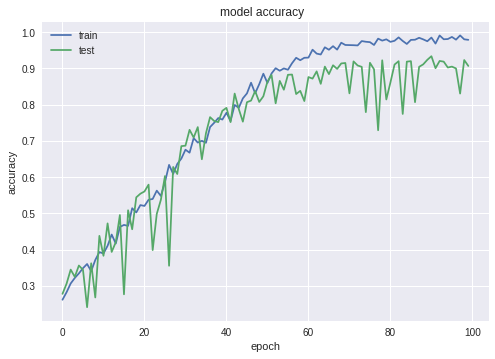

In [0]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'] )
plt.plot(history.history['val_categorical_accuracy'])
# plt.plot(history.history['val_acc'])
plt.title('model accuracy  ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

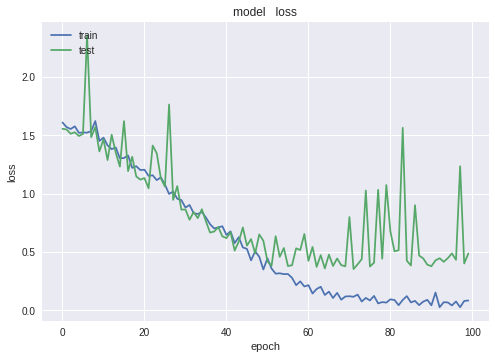

In [0]:
# summarize history for loss
plt.plot(history.history['loss'] )

plt.plot(history.history['val_loss'])
plt.title('model   loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()